In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from jax import config
config.update('jax_enable_x64', True)
import corner

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True*0)

In [3]:
def h_average(f0, eps):
    x = eps * T
    y = jnp.where(x==0., 1., (jnp.exp(x)-1) / x)
    return f0 * y

In [4]:
T = 10
tarr = jnp.linspace(0, T, int(1e3))

def exp_average(f0, eps):
    h = f0 * jnp.exp(eps*tarr)
    return jnp.mean(jnp.exp(-h))


def hexp_average(f0, eps):
    h = f0 * jnp.exp(eps*tarr)
    return jnp.mean(h*jnp.exp(-h))

In [5]:
h_average(1e-4, -0.1), hexp_average(1e-4, -0.1)

(DeviceArray(6.32120559e-05, dtype=float64, weak_type=True),
 DeviceArray(6.32129186e-05, dtype=float64))

In [6]:
1-h_average(1e-4, -0.1), exp_average(1e-4, -0.1)

(DeviceArray(0.99993679, dtype=float64, weak_type=True),
 DeviceArray(0.99993678, dtype=float64))

In [7]:
def model(N, Np):
    logf0 = numpyro.sample("logf0", dist.Uniform(-5, 0))
    f0 = numpyro.deterministic("f0", 10**logf0)
    eps = numpyro.sample("eps", dist.Uniform(-5, 5))

    #approximate likelihood (for h<<1)
    #h = numpyro.deterministic("h", h_average(f0, eps))
    #lnL = (N-Np) * jnp.log(1-h) + Np * jnp.log(h)
    
    lnL =  (N-Np) * jnp.log(exp_average(f0, eps)) + Np * jnp.log(hexp_average(f0, eps))
    numpyro.factor("loglike", lnL)

In [8]:
N = 382

In [9]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=2000, num_samples=2000)

## hot Jupiters

In [10]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, N, Np=9)

sample: 100%|█████████████████| 4000/4000 [00:04<00:00, 971.74it/s, 15 steps of size 3.93e-02. acc. prob=0.79]


In [11]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eps     -0.75      1.33     -0.41     -2.77      1.02     69.99      1.00
     logf0     -1.55      1.34     -1.04     -3.84     -0.01     68.62      1.01

Number of divergences: 1


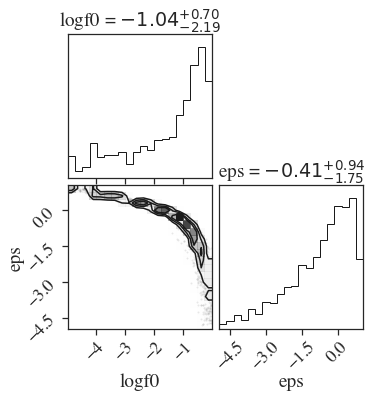

In [12]:
smp = mcmc.get_samples()
fig = corner.corner(np.array([smp['logf0'], smp['eps']]).T, labels=['logf0', 'eps'], show_titles=True)

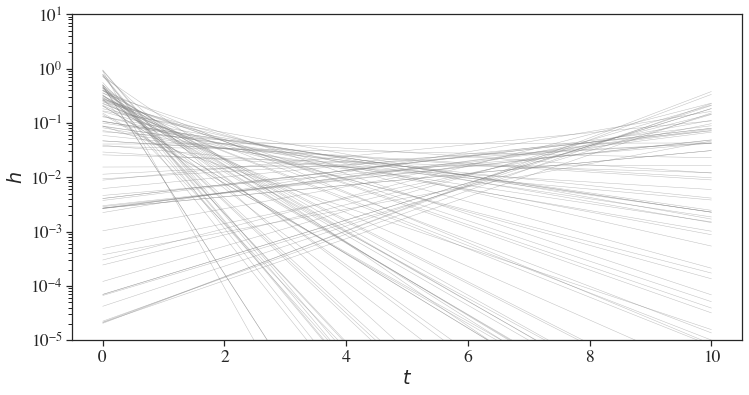

In [13]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp['f0'][idx], smp['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)

## cold Jupiters

In [14]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, N, Np=37)

sample: 100%|████████████████| 4000/4000 [00:03<00:00, 1047.66it/s, 15 steps of size 7.13e-02. acc. prob=0.96]


In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eps      0.00      0.20      0.01     -0.33      0.32    297.06      1.00
     logf0     -1.10      0.45     -1.05     -1.78     -0.39    315.29      1.00

Number of divergences: 0


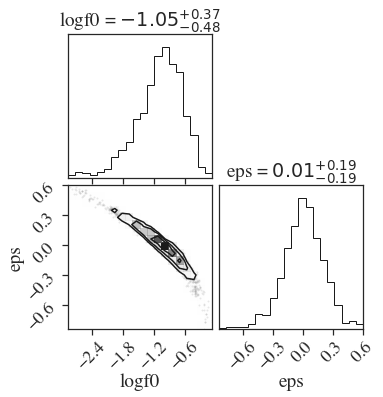

In [16]:
smp = mcmc.get_samples()
fig = corner.corner(np.array([smp['logf0'], smp['eps']]).T, labels=['logf0', 'eps'], show_titles=True)

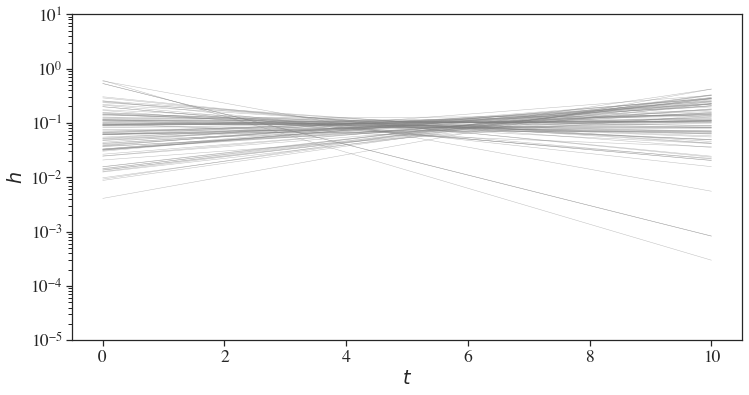

In [17]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp['f0'][idx], smp['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)

## HJ, 10x larger sample

In [18]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, N*10, Np=9*10)

sample: 100%|█████████████████| 4000/4000 [00:04<00:00, 946.24it/s, 15 steps of size 3.99e-02. acc. prob=0.93]


In [19]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eps     -0.01      0.31      0.00     -0.46      0.49    293.09      1.00
     logf0     -1.74      0.64     -1.63     -2.72     -0.84    280.17      1.00

Number of divergences: 0


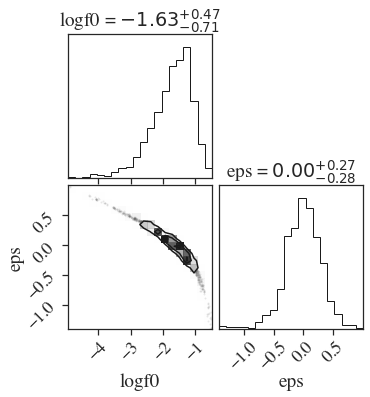

In [20]:
smp = mcmc.get_samples()
fig = corner.corner(np.array([smp['logf0'], smp['eps']]).T, labels=['logf0', 'eps'], show_titles=True)

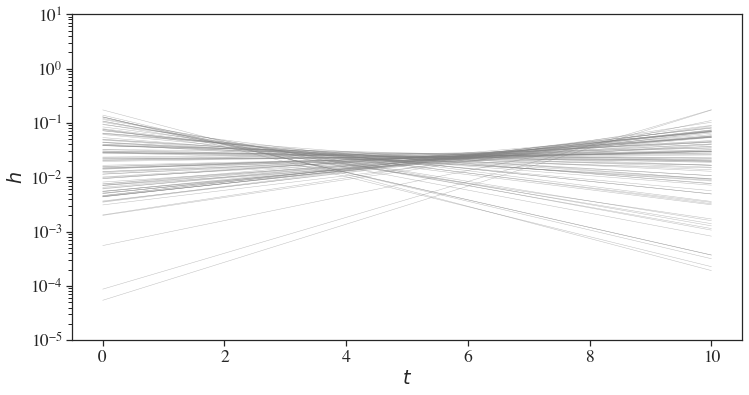

In [21]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp['f0'][idx], smp['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)

## correction1

In [22]:
def get_averages(f0, eps):    
    x = eps * tarr
    den = jnp.where(x==0., 1., jnp.exp(x) - 1.)
    correction = jnp.where(x==0., 1., x / den)
    h = f0 * jnp.exp(x) * correction
    #h = f0 * x * jnp.exp(x/2.) / jnp.sinh(x/2.) / 2.
    exp_av = jnp.mean(jnp.exp(-h))
    hexp_av = jnp.mean(h*jnp.exp(-h))
    return exp_av, hexp_av

In [23]:
def model2(N, Np):
    logf0 = numpyro.sample("logf0", dist.Uniform(-10., 5.))
    f0 = numpyro.deterministic("f0", 10**logf0)
    eps = numpyro.sample("eps", dist.Uniform(-5., 5.))
    
    """
    x = eps * tarr
    correction = jnp.where(x==0., 1, x / (jnp.exp(x) - 1.) )
    h = f0 * jnp.exp(x) * correction
    exp_av = jnp.mean(jnp.exp(-h))
    hexp_av = jnp.mean(h*jnp.exp(-h))
    """
    exp_av, hexp_av = get_averages(f0, eps)
    
    lnL =  numpyro.deterministic("lnL", (N-Np) * jnp.log(exp_av) + Np * jnp.log(hexp_av))
    numpyro.factor("loglike", lnL)

In [24]:
kernel2 = numpyro.infer.NUTS(model2, target_accept_prob=0.95)
mcmc2 = numpyro.infer.MCMC(kernel2, num_warmup=2000, num_samples=2000)

In [25]:
rng_key = random.PRNGKey(0)
mcmc2.run(rng_key, N, Np=9)

sample: 100%|██████████████████| 4000/4000 [00:04<00:00, 968.08it/s, 7 steps of size 5.49e-02. acc. prob=0.89]


In [26]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eps      0.78      2.45      0.85     -2.72      5.00     77.44      1.00
     logf0     -1.93      0.97     -2.29     -3.11     -0.36     70.09      1.00

Number of divergences: 0


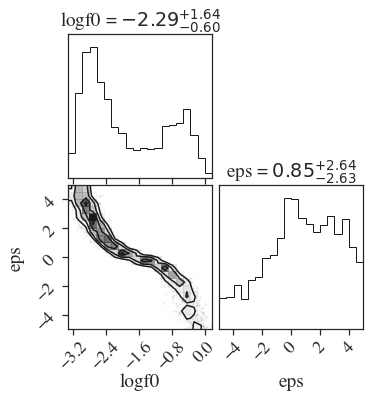

In [27]:
smp2 = mcmc2.get_samples()
fig = corner.corner(np.array([smp2['logf0'], smp2['eps']]).T, labels=['logf0', 'eps'], show_titles=True)

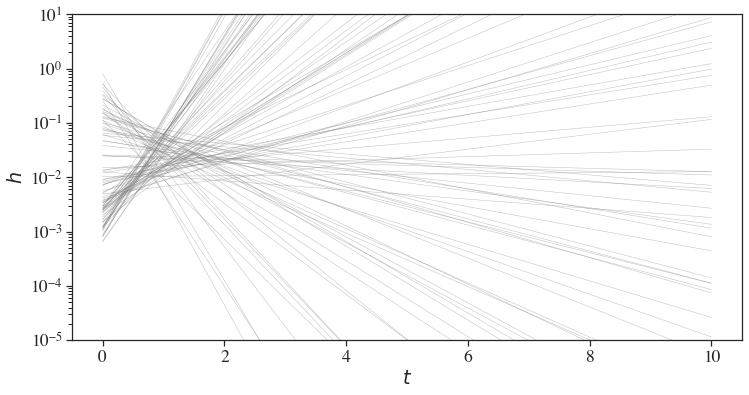

In [28]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp2['f0'][idx], smp2['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)

## correction2

In [29]:
def model3(N, Np):
    logf0 = numpyro.sample("logf0", dist.Uniform(-5, 0))
    f0 = numpyro.deterministic("f0", 10**logf0)
    #logtau = numpyro.sample("logtau", dist.Uniform(-3, 3))
    #tau = numpyro.deterministic("tau", 10**logtau)
    tau = numpyro.sample("tau", dist.Uniform(0, 1e2))
    eps = numpyro.deterministic("eps", -1./tau)

    lnL =  (N-Np) * jnp.log(exp_average(f0, eps)) + Np * jnp.log(hexp_average(f0, eps))
    #lneps = -jnp.log(jnp.abs(eps))
    
    numpyro.factor("loglike", lnL)

In [30]:
kernel3 = numpyro.infer.NUTS(model3, target_accept_prob=0.95)
mcmc3 = numpyro.infer.MCMC(kernel3, num_warmup=2000, num_samples=2000)

In [31]:
rng_key = random.PRNGKey(0)
mcmc3.run(rng_key, N, Np=9)

sample: 100%|█████████████████| 4000/4000 [00:03<00:00, 1219.40it/s, 1 steps of size 4.28e-01. acc. prob=0.92]


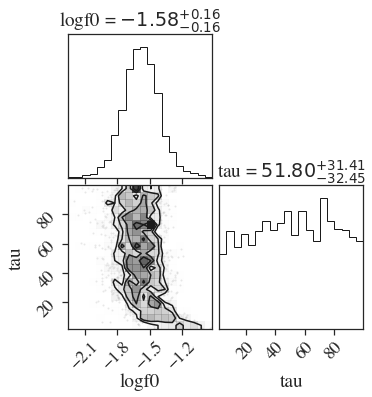

In [32]:
smp3 = mcmc3.get_samples()
fig = corner.corner(np.array([smp3['logf0'], smp3['tau']]).T, labels=['logf0', 'tau'], show_titles=True)

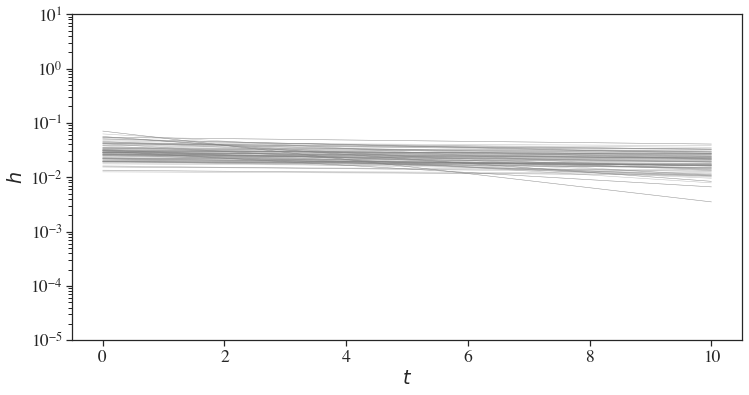

In [33]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp3['f0'][idx], smp3['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)

## correction3

In [49]:
def model4(N, Np):
    logf0 = numpyro.sample("logf0", dist.Uniform(-5, 0))
    f0 = numpyro.deterministic("f0", 10**logf0)
    theta = numpyro.sample("theta", dist.Uniform(-jnp.pi/2., jnp.pi/2.))
    eps = numpyro.deterministic("eps", jnp.tan(theta))
    lnL =  (N-Np) * jnp.log(exp_average(f0, eps)) + Np * jnp.log(hexp_average(f0, eps))
    numpyro.factor("loglike", lnL)

In [50]:
kernel4 = numpyro.infer.NUTS(model4, target_accept_prob=0.95)
mcmc4 = numpyro.infer.MCMC(kernel4, num_warmup=2000, num_samples=2000)

In [51]:
rng_key = random.PRNGKey(0)
mcmc4.run(rng_key, N, Np=9)

sample: 100%|█████████████████| 4000/4000 [00:04<00:00, 871.34it/s, 47 steps of size 4.39e-02. acc. prob=0.97]


In [52]:
mcmc4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     logf0     -1.75      1.15     -1.38     -3.61     -0.18    274.34      1.00
     theta     -0.15      0.52     -0.13     -0.85      0.79    260.36      1.00

Number of divergences: 0


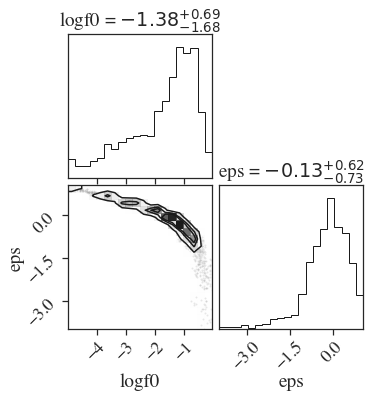

In [53]:
smp4 = mcmc4.get_samples()
fig = corner.corner(np.array([smp4['logf0'], smp4['eps']]).T, labels=['logf0', 'eps'], show_titles=True)

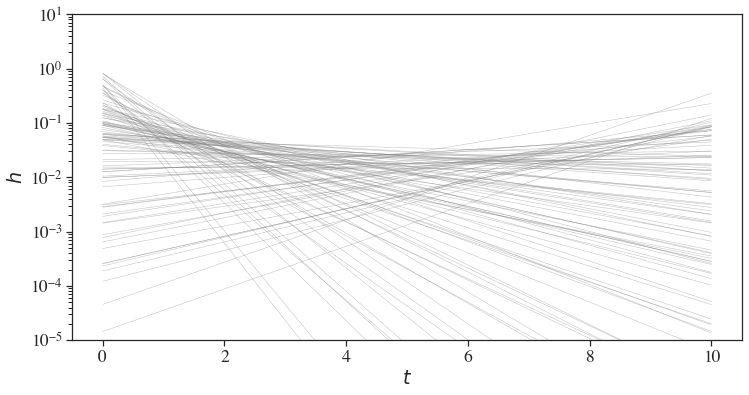

In [54]:
plt.ylabel("$h$")
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(1e-5, 1e1)
for idx in np.random.randint(0, 1000, 100):
    f0_, eps_ = smp4['f0'][idx], smp4['eps'][idx]
    plt.plot(tarr, f0_*jnp.exp(eps_*tarr), color='gray', lw=0.5, alpha=0.5)